In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    # Load the TensorBoard notebook extension
    %load_ext tensorboard   
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.2 GB  | Proc size: 387.0 MB
GPU RAM Free: 16160MB | Used: 0MB | Util   0% | Total 16160MB


In [3]:
!nvidia-smi

Wed Jul 28 02:35:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import imgaug as aug
import pandas as pd
import numpy as np
import datetime
import h5py
import cv2
import os

In [5]:
#!git clone https://github.com/nazmul0087/Covid19Detection
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Helper Functions
def show_image(img):
    '''
    Quick display of image in grayscale 
    '''
    if type(img) == 'str':
        img = plt.imread(img)
    plt.imshow(img, cmap = 'gray')
    plt.title('Example X-Ray scan')
    plt.grid(False)
    plt.axis('off')
    plt.show()

[INFO] loading images...

[INFO] creating a DataFrame...
                                               image            label
0  /content/drive/MyDrive/Thesis_covid 19/COVID-1...          1-COVID
1  /content/drive/MyDrive/Thesis_covid 19/COVID-1...         0-NORMAL
2  /content/drive/MyDrive/Thesis_covid 19/COVID-1...     Lung_Opacity
3  /content/drive/MyDrive/Thesis_covid 19/COVID-1...  Viral Pneumonia
4  /content/drive/MyDrive/Thesis_covid 19/COVID-1...         0-NORMAL
5  /content/drive/MyDrive/Thesis_covid 19/COVID-1...     Lung_Opacity
6  /content/drive/MyDrive/Thesis_covid 19/COVID-1...          1-COVID
7  /content/drive/MyDrive/Thesis_covid 19/COVID-1...  Viral Pneumonia
8  /content/drive/MyDrive/Thesis_covid 19/COVID-1...     Lung_Opacity
9  /content/drive/MyDrive/Thesis_covid 19/COVID-1...          1-COVID


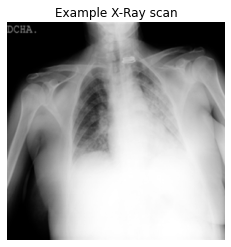


[INFO] one-hot encoding...
	Example scan label: 1-COVID
	One-hot encoded label:  1

[INFO] updating data DataFrame...
                                               image  label
0  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      1
1  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      0
2  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      2
3  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      3
4  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      0
5  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      2
6  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      1
7  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      3
8  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      2
9  /content/drive/MyDrive/Thesis_covid 19/COVID-1...      1


In [7]:
dataset_path="/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000"
#dataset_path = '/content/Covid19Detection/DATASET'

# Read all files from path
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))

data = []

# select number of classes to be loaded for Normal, Bacterial Pneumonia and Viral Pneumonia patients 
num_normal = 1000

n = 0 #initialize all 3 counters to limit the number of images loaded 
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    if label == '0-NORMAL' and n < num_normal:
      data.append((imagePath,label))
      n += 1

    elif label == '1-COVID':
      data.append((imagePath,label))

    elif label == 'Lung_Opacity':
      data.append((imagePath,label))

    elif label == 'Viral Pneumonia':
      data.append((imagePath,label))

print('\n[INFO] creating a DataFrame...')
# Get a pandas dataframe from the data we have in our list 
data = pd.DataFrame(data, columns=['image', 'label'],index=None)

# Shuffle the data 
data = data.sample(frac=1.).reset_index(drop=True)
print(data.head(10))

tmp_img = plt.imread(data["image"][0])
show_image(tmp_img)
del tmp_img

# perform one-hot encoding on the labels
print('\n[INFO] one-hot encoding...')
print('\tExample scan label:', data["label"][0])

data["label"] = LabelEncoder().fit_transform(data["label"])
print('\tOne-hot encoded label: ',data["label"][0])
print('\n[INFO] updating data DataFrame...')
print(data.head(10))

In [8]:
"""# select the number of sampels to be plotted for each class
sample_num = 7
normal_samples = (data[data['label']==0]['image'].iloc[30:30+sample_num]).tolist()
covid_samples = (data[data['label']==1]['image'].iloc[5:5+sample_num]).tolist()
Lung_Opacity = (data[data['label']==2]['image'].iloc[5:5+sample_num]).tolist()

samples = covid_samples + normal_samples
del covid_samples, normal_samples

color = 'black'

# Plot the data 
f, ax = plt.subplots(2,sample_num, figsize=(30,10))
for i in range(sample_num*2):
    img = cv2.imread(samples[i])
    img = cv2.resize(img, (299, 299))
    if i<sample_num:
        ax[0, i%sample_num].imshow(img, cmap='gray')
        ax[0, i%sample_num].set_title("Covid-19", fontsize=18, color = color)
    else:
        ax[1, i%sample_num].imshow(img, cmap='gray')
        ax[1, i%sample_num].set_title("Normal", fontsize=18, color = color)

    ax[i//sample_num, i%sample_num].axis('off')
    ax[i//sample_num, i%sample_num].set_aspect('auto')

plt.tight_layout()
plt.show()"""

'# select the number of sampels to be plotted for each class\nsample_num = 7\nnormal_samples = (data[data[\'label\']==0][\'image\'].iloc[30:30+sample_num]).tolist()\ncovid_samples = (data[data[\'label\']==1][\'image\'].iloc[5:5+sample_num]).tolist()\nLung_Opacity = (data[data[\'label\']==2][\'image\'].iloc[5:5+sample_num]).tolist()\n\nsamples = covid_samples + normal_samples\ndel covid_samples, normal_samples\n\ncolor = \'black\'\n\n# Plot the data \nf, ax = plt.subplots(2,sample_num, figsize=(30,10))\nfor i in range(sample_num*2):\n    img = cv2.imread(samples[i])\n    img = cv2.resize(img, (299, 299))\n    if i<sample_num:\n        ax[0, i%sample_num].imshow(img, cmap=\'gray\')\n        ax[0, i%sample_num].set_title("Covid-19", fontsize=18, color = color)\n    else:\n        ax[1, i%sample_num].imshow(img, cmap=\'gray\')\n        ax[1, i%sample_num].set_title("Normal", fontsize=18, color = color)\n\n    ax[i//sample_num, i%sample_num].axis(\'off\')\n    ax[i//sample_num, i%sample_num

In [9]:
train_data, test_data = train_test_split(data, test_size=0.20,shuffle=True,random_state=12)
train_data, valid_data = train_test_split(train_data, test_size=0.20, random_state=12)

print('\nNumber of training pairs: ', len(train_data))
print('Number of validation pairs: ', len(valid_data))
print('Number of testing pairs: ', len(test_data))


Number of training pairs:  2560
Number of validation pairs:  640
Number of testing pairs:  800


In [10]:
data['label'].value_counts()

3    1000
1    1000
2    1000
0    1000
Name: label, dtype: int64

	----- Entire Dataset ------
		 [1000 1000 1000 1000]

-- Train Set -- -- Validation Set -- -- Test Set --
   [669 632 631 628] 	      [179 162 151 148] 	         [218 206 193 183] 




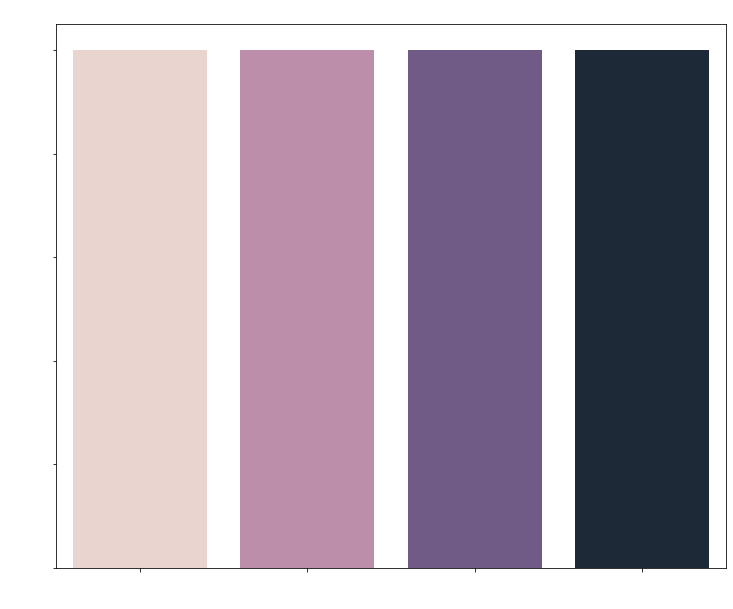

In [11]:
# Get the counts for each class
cases_count = data['label'].value_counts()
print('\t----- Entire Dataset ------')
print('\t\t', cases_count.ravel())

cases_count_tr = train_data['label'].value_counts()
cases_count_val = valid_data['label'].value_counts()
cases_count_tst = test_data['label'].value_counts()
print('\n-- Train Set -- -- Validation Set -- -- Test Set --')
print('  ', cases_count_tr.ravel(),'\t     ',cases_count_val.ravel(), '\t        ', cases_count_tst.ravel(), '\n\n')

# Plot the results 
plt.figure(figsize=(12,10))
sns.barplot(x=cases_count.index, y= cases_count.values, palette=sns.cubehelix_palette(4, start=2.5, rot=0.6))
plt.title('Frequency of Each Class in the Dataset', fontsize=14, color='w') #remove color = white if not in dark mode!
plt.xlabel('Case type', fontsize=12, color='w')
plt.ylabel('Count', fontsize=12, color='w')
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Covid-19 (1)'], color='w')
plt.yticks(color='w')
plt.show()

In [12]:
def get_arrays(df):
    print('[INFO] retreiving images from path...')
    images, labels = [], []

    img_paths = df.iloc[:,0].values # extract image paths from DataFrame
    labels_ = df.iloc[:,1].values # extract labels from DataFrame

    for i,path in enumerate(img_paths):
        # load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(path)

        # check if it's grayscale
        if image.shape[2]==1:
            print(image.shape[2])
            image = np.dstack([image, image, image])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image / 255.0 # Normalize images to range [0,1]
        # print('pre: ', labels_[i])
        encoded_label = tf.keras.utils.to_categorical(labels_[i], num_classes=4)
        # print('encoded: ',encoded_label )
        images.append(image)
        labels.append(encoded_label)

    return np.array(images), np.array(labels)

In [13]:
trainX, trainY = get_arrays(train_data)
validX, validY = get_arrays(valid_data)
testX, testY = get_arrays(test_data)

[INFO] retreiving images from path...
[INFO] retreiving images from path...
[INFO] retreiving images from path...


In [14]:
def build_model(baseModel):

      # Make all pre-trained layers non-trainable 
      for layer in baseModel.layers[:-3]:
          layer.trainable = False

      # Add trainable fully-connected (FC) layers for predictions
      newModel = baseModel.output
      newModel = tf.keras.layers.AveragePooling2D(pool_size=(4, 4),name="Averagea_Pooling")(newModel)
      newModel = tf.keras.layers.Flatten(name="flatten")(newModel)
      #newModel = tf.keras.layers.Dense(64, activation="relu")(newModel)
      #newModel = tf.keras.layers.Dropout(0.5)(newModel)
      
      #newModel = tf.keras.layers.Dense(32, activation="sigmoid",name="Dense20")(newModel)
      #newModel = tf.keras.layers.Dense(2, activation="sigmoid")(newModel)
      #newModel = tf.keras.layers.Dropout(0.5)(newModel)
      newModel = tf.keras.layers.Dense(4, activation="sigmoid", name="Dense_final")(newModel)




      # Stack the FC layers on top of Resnet model
      model = tf.keras.models.Model(inputs=baseModel.input, outputs=newModel, name='Covid19_Detector_Resnet_Mod')

      return model

baseModel = classifier = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,
            input_tensor = tf.keras.layers.Input(shape=(224,224,3)))
model = build_model(baseModel)

model.summary()

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=["accuracy"])

# initialize the training data augmentation object
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale= 1 / 255.0,
    rotation_range=15,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode="nearest")

  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', 
verbose=1,
patience=15,
mode='max',
restore_best_weights=True
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15, verbose=1, 
                                                                    mode='auto', min_delta=0.00001, cooldown=0, min_lr=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('ResnetMC_weights.h5', 
                                                      monitor='val_accuracy', verbose=1, save_best_only=True, 
                                                      save_weights_only=True, mode='max')


callbacks = [early_stopping, reduce_on_plateau, model_checkpoint]

batch_size = 32
epochs = 100
results = model.fit(
    train_datagen.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=valid_datagen.flow(validX, validY, batch_size=batch_size),
    validation_steps=len(validX) // batch_size,
    class_weight = None,
    epochs=epochs,
    callbacks=callbacks
)

94773248/94765736 [==============================] - 2s 0us/step
Model: "Covid19_Detector_Resnet_Mod"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______

In [15]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
print('Number of test scans: ', len(testX))
print('Predicted class probabilities:')
print()

for n in range(len(predIdxs)):
    my_formatted_list = ['%.2f' % elem for elem in predIdxs[n]]
    print(f'{n}:  ', *my_formatted_list)

# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome:')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)


[INFO] evaluating network...
Number of test scans:  800
Predicted class probabilities:

0:   0.52 0.54 0.29 0.00
1:   0.05 0.88 0.06 0.05
2:   0.00 0.31 0.41 0.18
3:   0.00 0.27 0.71 0.06
4:   0.02 0.20 0.70 0.01
5:   0.01 0.66 0.10 0.18
6:   0.96 0.00 0.05 0.02
7:   0.04 0.06 0.61 0.10
8:   0.15 0.01 0.37 0.41
9:   0.05 0.46 0.44 0.03
10:   0.01 0.07 0.11 0.81
11:   0.02 0.17 0.13 0.76
12:   0.08 0.09 0.38 0.01
13:   0.02 0.51 0.25 0.15
14:   0.02 0.71 0.17 0.10
15:   0.10 0.00 0.01 0.99
16:   0.01 0.45 0.36 0.12
17:   0.95 0.00 0.01 0.29
18:   0.25 0.02 0.01 0.89
19:   0.04 0.01 0.21 0.63
20:   0.00 0.25 0.58 0.10
21:   0.01 0.05 0.65 0.25
22:   0.29 0.01 0.05 0.35
23:   0.17 0.00 0.06 0.72
24:   0.09 0.33 0.17 0.14
25:   0.00 0.57 0.26 0.13
26:   0.01 0.81 0.12 0.06
27:   0.03 0.06 0.06 0.85
28:   0.19 0.10 0.57 0.01
29:   0.01 0.18 0.74 0.02
30:   0.01 0.02 0.06 0.93
31:   0.97 0.00 0.02 0.18
32:   0.03 0.76 0.29 0.03
33:   0.01 0.25 0.52 0.14
34:   0.00 0.81 0.35 0.03
35:   0.22 0

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm



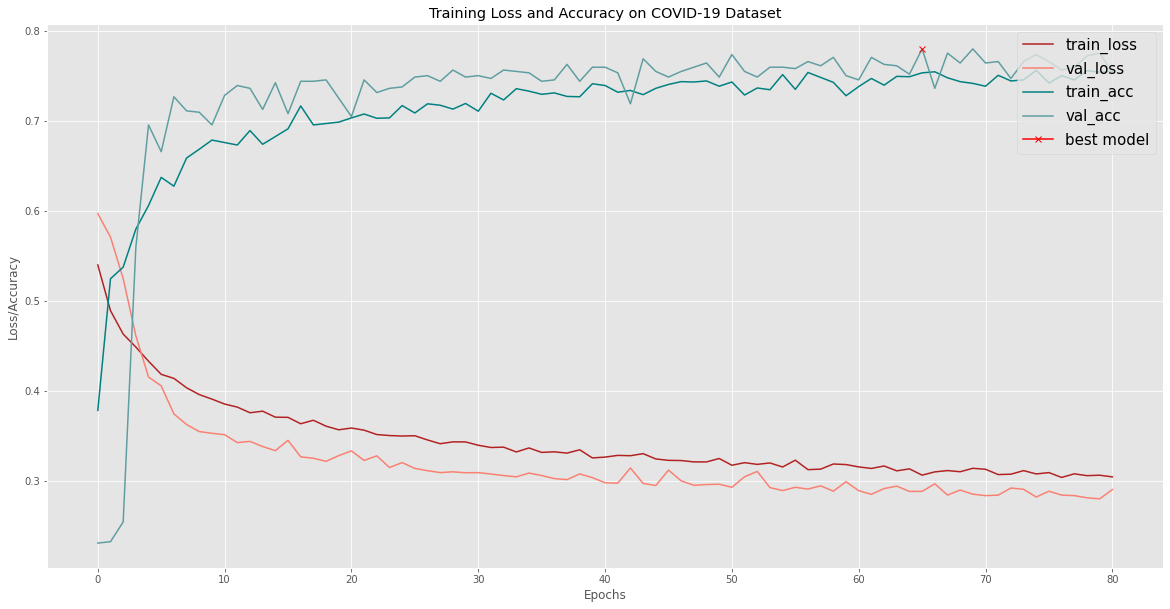

In [17]:
N = len(results.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), results.history["accuracy"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), results.history["val_accuracy"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", fontsize=15)
plt.savefig('loss_curve_xception.pdf', format='pdf')
plt.show()

In [18]:


model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])
predicted_metrics = model.evaluate(testX, testY,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
    print(name, ': ', "%.3f" % value)
print()


loss :  0.674
accuracy :  0.749



In [19]:
#saving the model architecture to json file for future use

model_json = model.to_json()
with open("multiclass_covid_resnet.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
score = model.evaluate(testX, testY)
print('Test Accuracy: {}'.format(score[1]))

25/25 [==============================] - 1s 36ms/step - loss: 0.6739 - accuracy: 0.7487
Test Accuracy: 0.7487499713897705


In [21]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [22]:
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

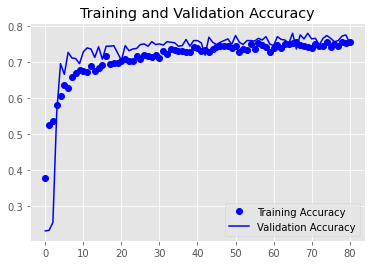

In [23]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

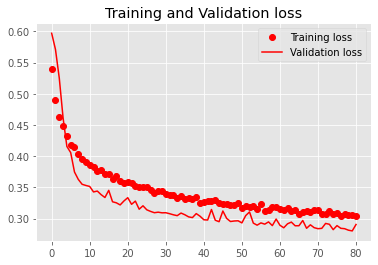

In [24]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [25]:
#predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model.predict(testX), axis=-1)
y_true = np.argmax(testY, axis=-1)

In [26]:
y_true.shape

(800,)

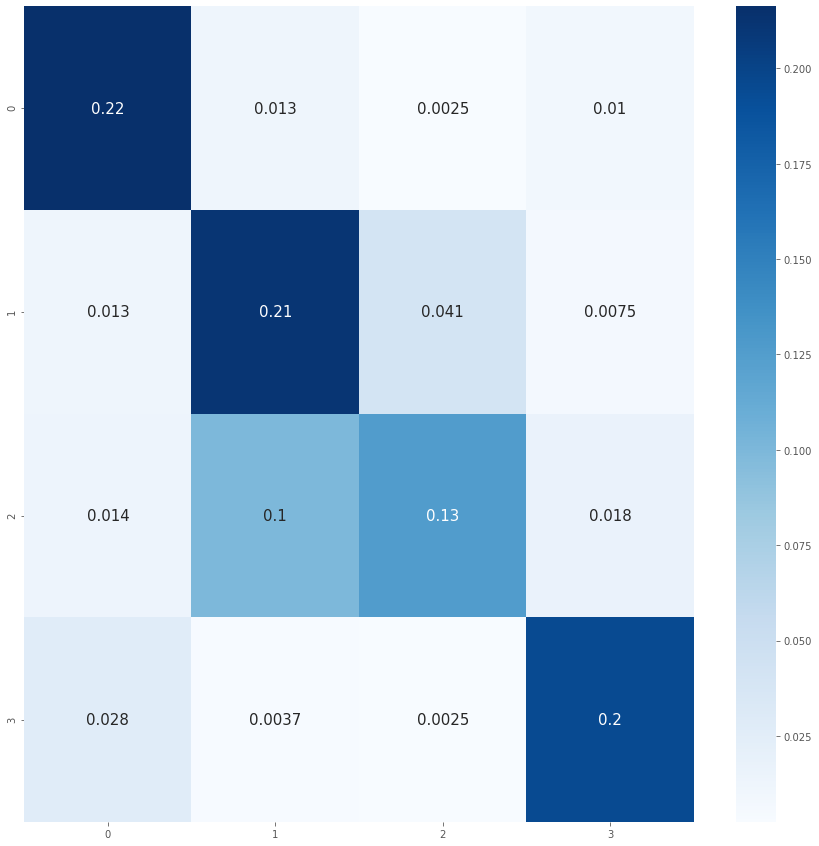

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes, normalize='all')
plt.figure(figsize = (15, 15))
sns.heatmap(cm,cmap=plt.cm.Blues, annot = True, annot_kws={'size': 15})

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       193
           1       0.65      0.78      0.70       218
           2       0.73      0.49      0.59       206
           3       0.85      0.85      0.85       183

    accuracy                           0.75       800
   macro avg       0.76      0.75      0.75       800
weighted avg       0.75      0.75      0.74       800



In [29]:
!pip install scikit-plot

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


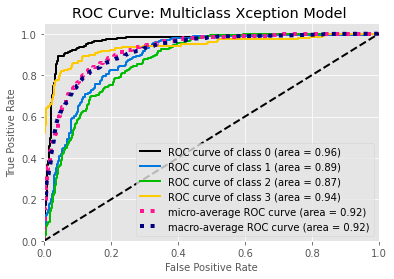

In [30]:
import scikitplot as skplt
#y_probas= model.predict(testX, batch_size=batch_size)
y_probas=model.predict(testX)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.title("ROC Curve: Multiclass Xception Model ")
plt.show()

In [31]:
model.save_weights('multiclass_covid_resnet.hdf5')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


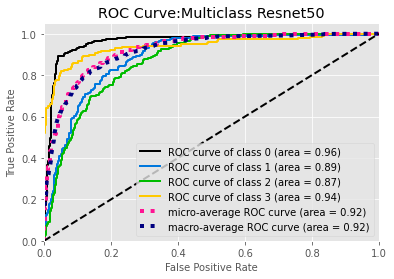

In [32]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true=trueIdxs
y_pred=predIdxs
y_probas= model.predict(testX, batch_size=batch_size)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.title("ROC Curve:Multiclass Resnet50")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: Resnet Multiclass')

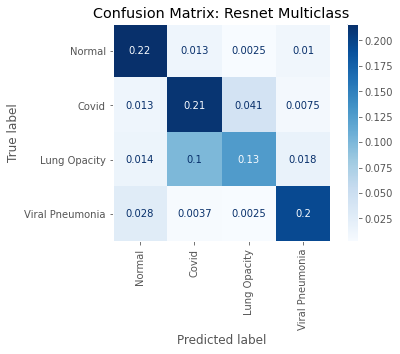

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(trueIdxs, predIdxs, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal','Covid','Lung Opacity', 'Viral Pneumonia'])
cmd.plot(cmap=plt.cm.Blues,xticks_rotation='vertical')
plt.grid(None)
plt.title("Confusion Matrix: Resnet Multiclass")

# Explainable AI

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [35]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 512).astype("uint8") # change to 255 from 512
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [36]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [37]:
# Image Path

#Normal
path1='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-41.png'

path2='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-6.png'

#Covid

path3='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-359.png'
path4="/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-372.png"

#Lung_Opacity

path5='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-10.png'
path6='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-1000.png'
#Viral Pneumonia

path7='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-10.png'
path8='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-1000.png'



In [38]:

#declare a Variable named layer

Layer_to_examine='conv5_block3_3_conv'

sh=224

#Normal
path1='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-41.png'

path2='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-6.png'

#Covid

path3='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-359.png'
path4="/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-372.png"

#Lung_Opacity

path5='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-10.png'
path6='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-1000.png'
#Viral Pneumonia

path7='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-10.png'
path8='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-1000.png'



## Do not change upto certain portion; then please edit block or layer
image1 = cv2.imread(path1)
image1 = cv2.resize(image1, (sh, sh))
image1 = image1.astype('float32') / 255
image1 = np.expand_dims(image1, axis=0)

preds = model.predict(image1) 
i1 = np.argmax(preds[0])
print(i1)

image2 = cv2.imread(path2)
image2 = cv2.resize(image2, (sh, sh))
image2 = image2.astype('float32') / 255
image2 = np.expand_dims(image2, axis=0)

preds = model.predict(image2) 
i2 = np.argmax(preds[0])
print(i2)

image3 = cv2.imread(path3)
image3 = cv2.resize(image3, (sh, sh))
image3 = image3.astype('float32') / 255
image3 = np.expand_dims(image3, axis=0)

preds = model.predict(image3) 
i3 = np.argmax(preds[0])
print(i3)

image4 = cv2.imread(path4)
image4 = cv2.resize(image4, (sh, sh))
image4 = image4.astype('float32') / 255
image4 = np.expand_dims(image4, axis=0)

preds = model.predict(image4) 
i4 = np.argmax(preds[0])
print(i4)

#image 5
image5 = cv2.imread(path5)
image5 = cv2.resize(image5, (sh, sh))
image5 = image5.astype('float32') / 255
image5 = np.expand_dims(image5, axis=0)

preds = model.predict(image5) 
i5 = np.argmax(preds[0])
print(i5)

#image 6
image6 = cv2.imread(path6)
image6 = cv2.resize(image6, (sh, sh))
image6 = image6.astype('float32') / 255
image6 = np.expand_dims(image6, axis=0)

preds = model.predict(image6) 
i6 = np.argmax(preds[0])
print(i6)

#image 7
image7 = cv2.imread(path7)
image7 = cv2.resize(image7, (sh, sh))
image7 = image7.astype('float32') / 255
image7 = np.expand_dims(image7, axis=0)

preds = model.predict(image7) 
i7 = np.argmax(preds[0])
print(i7)


##image 8
image8 = cv2.imread(path8)
image8 = cv2.resize(image8, (sh, sh))
image8 = image8.astype('float32') / 255
image8 = np.expand_dims(image8, axis=0)

preds = model.predict(image8) 
i8 = np.argmax(preds[0])
print(i8)


# Do not change opto this portion

##For my reference change block only

# Image 1
icam1 = GradCAM(model, i1, Layer_to_examine) 
heatmap1 = icam1.compute_heatmap(image1)
heatmap1 = cv2.resize(heatmap1, (sh, sh))

image1 = cv2.imread(path1)
image1 = cv2.resize(image1, (sh, sh))
print(heatmap1.shape, image1.shape)

(heatmap1, output1) = icam1.overlay_heatmap(heatmap1, image1, alpha=0.5)


# image 2
icam2 = GradCAM(model, i2, Layer_to_examine) 
heatmap2 = icam2.compute_heatmap(image2)
heatmap2 = cv2.resize(heatmap2, (sh, sh))

image2 = cv2.imread(path2)
image2 = cv2.resize(image2, (sh, sh))
print(heatmap2.shape, image2.shape)

(heatmap2, output2) = icam2.overlay_heatmap(heatmap2, image2, alpha=0.5)

# Image 3
icam3 = GradCAM(model, i3, Layer_to_examine) 
heatmap3 = icam3.compute_heatmap(image3)
heatmap3 = cv2.resize(heatmap3, (sh, sh))

image3 = cv2.imread(path3)
image3 = cv2.resize(image3, (sh, sh))
print(heatmap3.shape, image3.shape)

(heatmap3, output3) = icam3.overlay_heatmap(heatmap3, image3, alpha=0.5)


# Image 4
icam4 = GradCAM(model, i4, Layer_to_examine) 
heatmap4 = icam4.compute_heatmap(image4)
heatmap4 = cv2.resize(heatmap4, (sh, sh))

image4 = cv2.imread(path4)
image4 = cv2.resize(image4, (sh, sh))
print(heatmap4.shape, image4.shape)

(heatmap4, output4) = icam4.overlay_heatmap(heatmap4, image4, alpha=0.5)



# Image 5
icam5 = GradCAM(model, i5, Layer_to_examine) 
heatmap5 = icam5.compute_heatmap(image5)
heatmap5 = cv2.resize(heatmap5, (sh, sh))

image5 = cv2.imread(path5)
image5 = cv2.resize(image5, (sh, sh))
print(heatmap5.shape, image5.shape)

(heatmap5, output5) = icam5.overlay_heatmap(heatmap5, image5, alpha=0.5)


# Image 6
icam6 = GradCAM(model, i6, Layer_to_examine) 
heatmap6 = icam6.compute_heatmap(image6)
heatmap6 = cv2.resize(heatmap6, (sh, sh))

image6 = cv2.imread(path6)
image6 = cv2.resize(image6, (sh, sh))
print(heatmap6.shape, image6.shape)

(heatmap6, output6) = icam6.overlay_heatmap(heatmap6, image6, alpha=0.6)

# Image 7
icam7 = GradCAM(model, i7, Layer_to_examine) 
heatmap7 = icam7.compute_heatmap(image7)
heatmap7 = cv2.resize(heatmap7, (sh, sh))

image7 = cv2.imread(path7)
image7 = cv2.resize(image7, (sh, sh))
print(heatmap7.shape, image7.shape)

(heatmap7, output7) = icam7.overlay_heatmap(heatmap7, image7, alpha=0.7)


# Image 8
icam8 = GradCAM(model, i8, Layer_to_examine) 
heatmap8 = icam8.compute_heatmap(image8)
heatmap8 = cv2.resize(heatmap8, (sh, sh))

image8 = cv2.imread(path8)
image8 = cv2.resize(image8, (sh, sh))
print(heatmap8.shape, image8.shape)

(heatmap8, output8) = icam8.overlay_heatmap(heatmap8, image8, alpha=0.8)



1
2
1
1
2
2
3
0
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)


image1:Normal


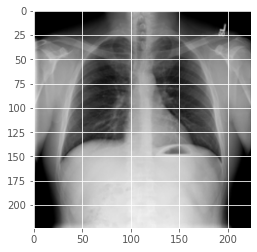

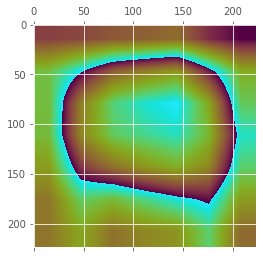

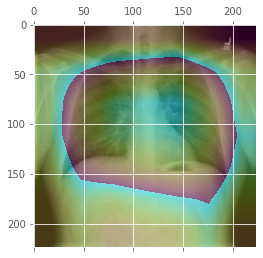

image2: Normal


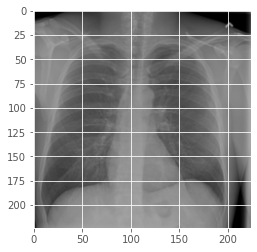

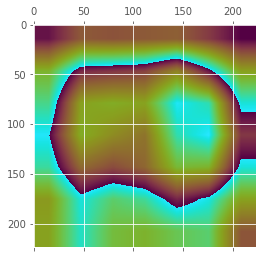

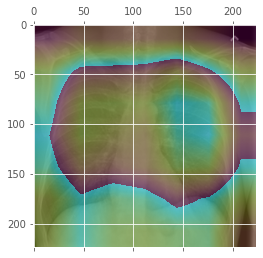

image2: Covid


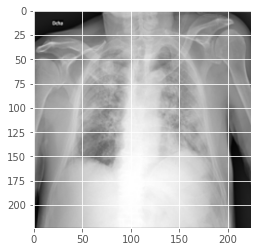

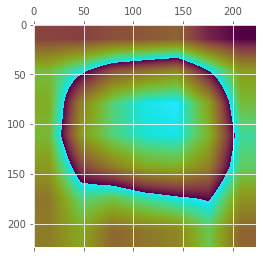

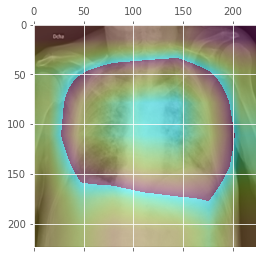

image2: Covid


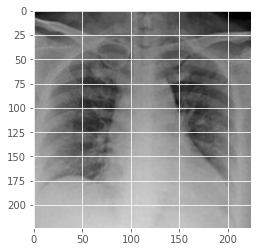

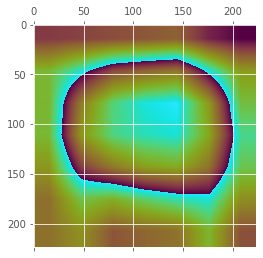

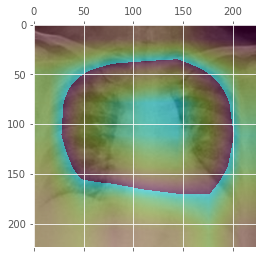

image5:Lung Opacity


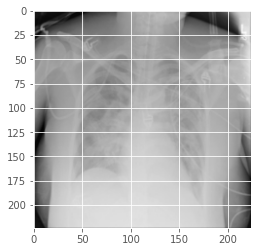

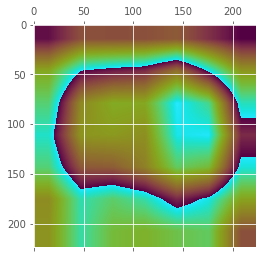

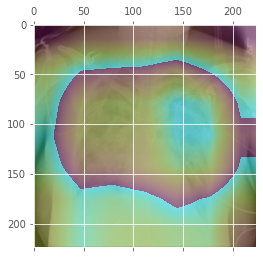

image6: Lung Opacity


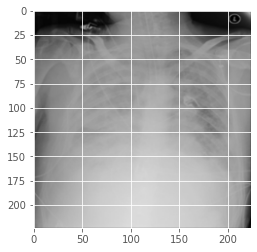

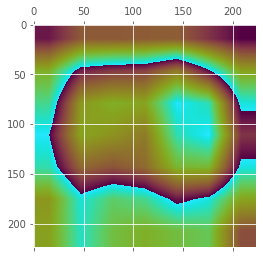

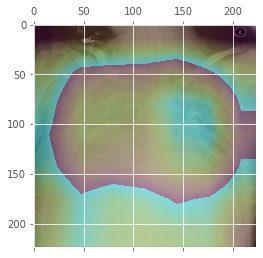

image7: Viral Pneumonia


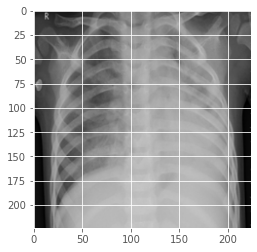

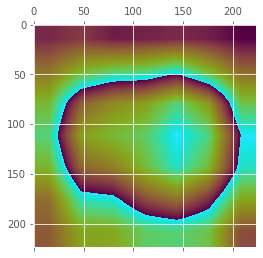

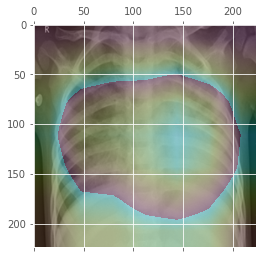

image8: Viral Pneumonia


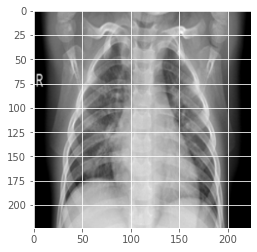

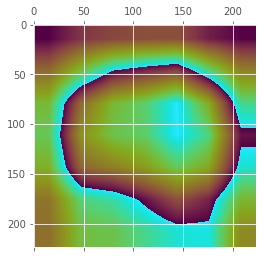

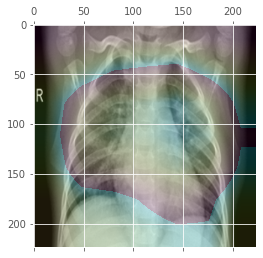

In [39]:
#image1
print("image1:Normal")
plt.imshow(image1)
plt.show()
plt.matshow(heatmap1)
plt.show()
plt.matshow(output1) 
plt.show()

#image 2
print("image2: Normal")
plt.imshow(image2)
plt.show()
plt.matshow(heatmap2)
plt.show()
plt.matshow(output2) 
plt.show()

print("image2: Covid")
#image 3
plt.imshow(image3)
plt.show()
plt.matshow(heatmap3)
plt.show()
plt.matshow(output3) 
plt.show()

print("image2: Covid")
#image 4
plt.imshow(image4)
plt.show()
plt.matshow(heatmap4)
plt.show()
plt.matshow(output4) 
plt.show()

#image5
print("image5:Lung Opacity")
plt.imshow(image5)
plt.show()
plt.matshow(heatmap5)
plt.show()
plt.matshow(output5) 
plt.show()

#image 6
print("image6: Lung Opacity")
plt.imshow(image6)
plt.show()
plt.matshow(heatmap6)
plt.show()
plt.matshow(output6) 
plt.show()

print("image7: Viral Pneumonia")
#image 7
plt.imshow(image7)
plt.show()
plt.matshow(heatmap7)
plt.show()
plt.matshow(output7) 
plt.show()

print("image8: Viral Pneumonia")
#image 8
plt.imshow(image8)
plt.show()
plt.matshow(heatmap8)
plt.show()
plt.matshow(output8) 
plt.show()



In [40]:

#declare a Variable named layer

Layer_to_examine='conv5_block3_2_conv'

sh=224

#Normal
path1='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-41.png'

path2='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-6.png'

#Covid

path3='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-359.png'
path4="/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-372.png"

#Lung_Opacity

path5='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-10.png'
path6='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-1000.png'
#Viral Pneumonia

path7='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-10.png'
path8='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-1000.png'



## Do not change upto certain portion; then please edit block or layer
image1 = cv2.imread(path1)
image1 = cv2.resize(image1, (sh, sh))
image1 = image1.astype('float32') / 255
image1 = np.expand_dims(image1, axis=0)

preds = model.predict(image1) 
i1 = np.argmax(preds[0])
print(i1)

image2 = cv2.imread(path2)
image2 = cv2.resize(image2, (sh, sh))
image2 = image2.astype('float32') / 255
image2 = np.expand_dims(image2, axis=0)

preds = model.predict(image2) 
i2 = np.argmax(preds[0])
print(i2)

image3 = cv2.imread(path3)
image3 = cv2.resize(image3, (sh, sh))
image3 = image3.astype('float32') / 255
image3 = np.expand_dims(image3, axis=0)

preds = model.predict(image3) 
i3 = np.argmax(preds[0])
print(i3)

image4 = cv2.imread(path4)
image4 = cv2.resize(image4, (sh, sh))
image4 = image4.astype('float32') / 255
image4 = np.expand_dims(image4, axis=0)

preds = model.predict(image4) 
i4 = np.argmax(preds[0])
print(i4)

#image 5
image5 = cv2.imread(path5)
image5 = cv2.resize(image5, (sh, sh))
image5 = image5.astype('float32') / 255
image5 = np.expand_dims(image5, axis=0)

preds = model.predict(image5) 
i5 = np.argmax(preds[0])
print(i5)

#image 6
image6 = cv2.imread(path6)
image6 = cv2.resize(image6, (sh, sh))
image6 = image6.astype('float32') / 255
image6 = np.expand_dims(image6, axis=0)

preds = model.predict(image6) 
i6 = np.argmax(preds[0])
print(i6)

#image 7
image7 = cv2.imread(path7)
image7 = cv2.resize(image7, (sh, sh))
image7 = image7.astype('float32') / 255
image7 = np.expand_dims(image7, axis=0)

preds = model.predict(image7) 
i7 = np.argmax(preds[0])
print(i7)


##image 8
image8 = cv2.imread(path8)
image8 = cv2.resize(image8, (sh, sh))
image8 = image8.astype('float32') / 255
image8 = np.expand_dims(image8, axis=0)

preds = model.predict(image8) 
i8 = np.argmax(preds[0])
print(i8)


# Do not change opto this portion

##For my reference change block only

# Image 1
icam1 = GradCAM(model, i1, Layer_to_examine) 
heatmap1 = icam1.compute_heatmap(image1)
heatmap1 = cv2.resize(heatmap1, (sh, sh))

image1 = cv2.imread(path1)
image1 = cv2.resize(image1, (sh, sh))
print(heatmap1.shape, image1.shape)

(heatmap1, output1) = icam1.overlay_heatmap(heatmap1, image1, alpha=0.5)


# image 2
icam2 = GradCAM(model, i2, Layer_to_examine) 
heatmap2 = icam2.compute_heatmap(image2)
heatmap2 = cv2.resize(heatmap2, (sh, sh))

image2 = cv2.imread(path2)
image2 = cv2.resize(image2, (sh, sh))
print(heatmap2.shape, image2.shape)

(heatmap2, output2) = icam2.overlay_heatmap(heatmap2, image2, alpha=0.5)

# Image 3
icam3 = GradCAM(model, i3, Layer_to_examine) 
heatmap3 = icam3.compute_heatmap(image3)
heatmap3 = cv2.resize(heatmap3, (sh, sh))

image3 = cv2.imread(path3)
image3 = cv2.resize(image3, (sh, sh))
print(heatmap3.shape, image3.shape)

(heatmap3, output3) = icam3.overlay_heatmap(heatmap3, image3, alpha=0.5)


# Image 4
icam4 = GradCAM(model, i4, Layer_to_examine) 
heatmap4 = icam4.compute_heatmap(image4)
heatmap4 = cv2.resize(heatmap4, (sh, sh))

image4 = cv2.imread(path4)
image4 = cv2.resize(image4, (sh, sh))
print(heatmap4.shape, image4.shape)

(heatmap4, output4) = icam4.overlay_heatmap(heatmap4, image4, alpha=0.5)



# Image 5
icam5 = GradCAM(model, i5, Layer_to_examine) 
heatmap5 = icam5.compute_heatmap(image5)
heatmap5 = cv2.resize(heatmap5, (sh, sh))

image5 = cv2.imread(path5)
image5 = cv2.resize(image5, (sh, sh))
print(heatmap5.shape, image5.shape)

(heatmap5, output5) = icam5.overlay_heatmap(heatmap5, image5, alpha=0.5)


# Image 6
icam6 = GradCAM(model, i6, Layer_to_examine) 
heatmap6 = icam6.compute_heatmap(image6)
heatmap6 = cv2.resize(heatmap6, (sh, sh))

image6 = cv2.imread(path6)
image6 = cv2.resize(image6, (sh, sh))
print(heatmap6.shape, image6.shape)

(heatmap6, output6) = icam6.overlay_heatmap(heatmap6, image6, alpha=0.6)

# Image 7
icam7 = GradCAM(model, i7, Layer_to_examine) 
heatmap7 = icam7.compute_heatmap(image7)
heatmap7 = cv2.resize(heatmap7, (sh, sh))

image7 = cv2.imread(path7)
image7 = cv2.resize(image7, (sh, sh))
print(heatmap7.shape, image7.shape)

(heatmap7, output7) = icam7.overlay_heatmap(heatmap7, image7, alpha=0.7)


# Image 8
icam8 = GradCAM(model, i8, Layer_to_examine) 
heatmap8 = icam8.compute_heatmap(image8)
heatmap8 = cv2.resize(heatmap8, (sh, sh))

image8 = cv2.imread(path8)
image8 = cv2.resize(image8, (sh, sh))
print(heatmap8.shape, image8.shape)

(heatmap8, output8) = icam8.overlay_heatmap(heatmap8, image8, alpha=0.8)



1
2
1
1
2
2
3
0
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)


image1:Normal


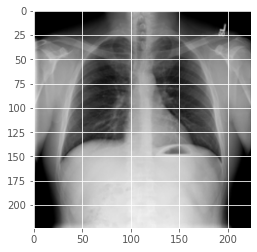

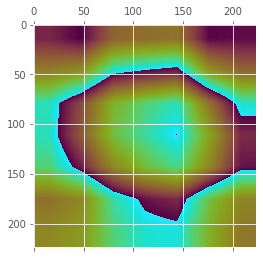

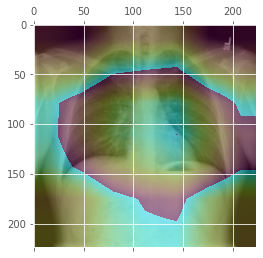

image2: Normal


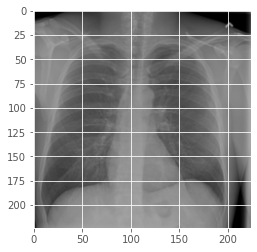

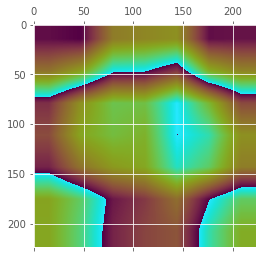

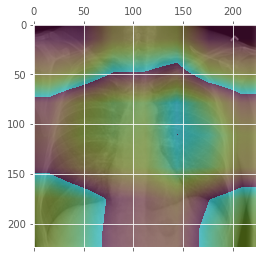

image2: Covid


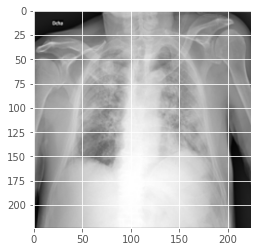

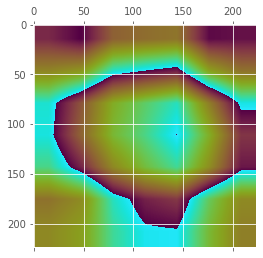

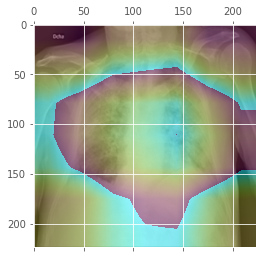

image2: Covid


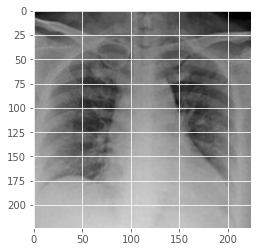

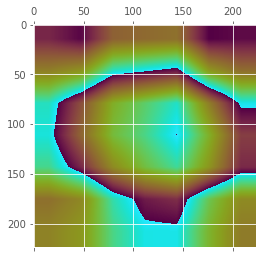

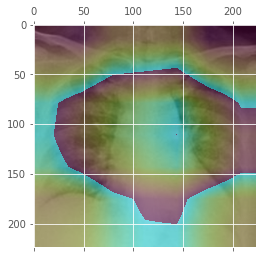

image5:Lung Opacity


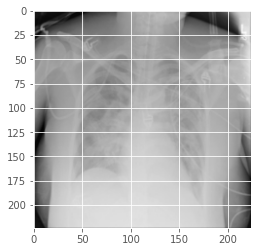

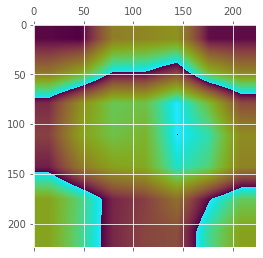

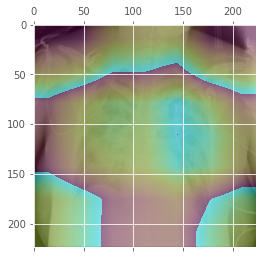

image6: Lung Opacity


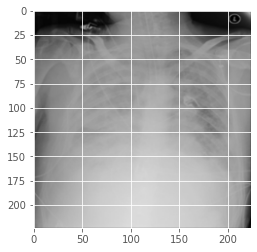

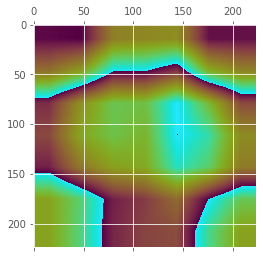

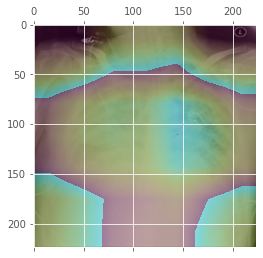

image7: Viral Pneumonia


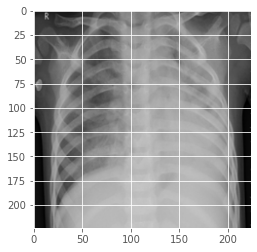

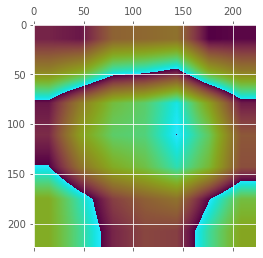

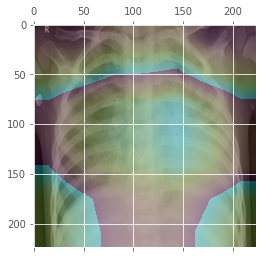

image8: Viral Pneumonia


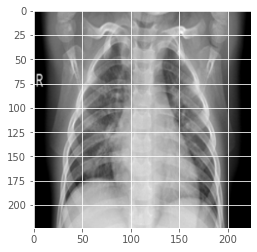

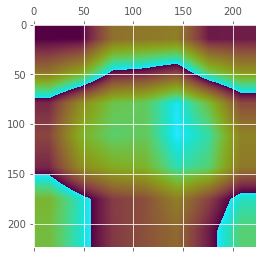

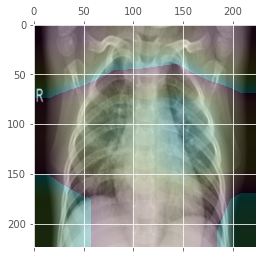

In [41]:
#image1
print("image1:Normal")
plt.imshow(image1)
plt.show()
plt.matshow(heatmap1)
plt.show()
plt.matshow(output1) 
plt.show()

#image 2
print("image2: Normal")
plt.imshow(image2)
plt.show()
plt.matshow(heatmap2)
plt.show()
plt.matshow(output2) 
plt.show()

print("image2: Covid")
#image 3
plt.imshow(image3)
plt.show()
plt.matshow(heatmap3)
plt.show()
plt.matshow(output3) 
plt.show()

print("image2: Covid")
#image 4
plt.imshow(image4)
plt.show()
plt.matshow(heatmap4)
plt.show()
plt.matshow(output4) 
plt.show()

#image5
print("image5:Lung Opacity")
plt.imshow(image5)
plt.show()
plt.matshow(heatmap5)
plt.show()
plt.matshow(output5) 
plt.show()

#image 6
print("image6: Lung Opacity")
plt.imshow(image6)
plt.show()
plt.matshow(heatmap6)
plt.show()
plt.matshow(output6) 
plt.show()

print("image7: Viral Pneumonia")
#image 7
plt.imshow(image7)
plt.show()
plt.matshow(heatmap7)
plt.show()
plt.matshow(output7) 
plt.show()

print("image8: Viral Pneumonia")
#image 8
plt.imshow(image8)
plt.show()
plt.matshow(heatmap8)
plt.show()
plt.matshow(output8) 
plt.show()



In [42]:

#declare a Variable named layer

Layer_to_examine='conv5_block3_1_conv'

sh=224

#Normal
path1='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-41.png'

path2='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/0-NORMAL/Normal-6.png'

#Covid

path3='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-359.png'
path4="/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/1-COVID/COVID-372.png"

#Lung_Opacity

path5='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-10.png'
path6='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Lung_Opacity/Lung_Opacity-1000.png'
#Viral Pneumonia

path7='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-10.png'
path8='/content/drive/MyDrive/Thesis_covid 19/COVID-19_Radiography_Dataset_V1_1000/Viral Pneumonia/Viral Pneumonia-1000.png'



## Do not change upto certain portion; then please edit block or layer
image1 = cv2.imread(path1)
image1 = cv2.resize(image1, (sh, sh))
image1 = image1.astype('float32') / 255
image1 = np.expand_dims(image1, axis=0)

preds = model.predict(image1) 
i1 = np.argmax(preds[0])
print(i1)

image2 = cv2.imread(path2)
image2 = cv2.resize(image2, (sh, sh))
image2 = image2.astype('float32') / 255
image2 = np.expand_dims(image2, axis=0)

preds = model.predict(image2) 
i2 = np.argmax(preds[0])
print(i2)

image3 = cv2.imread(path3)
image3 = cv2.resize(image3, (sh, sh))
image3 = image3.astype('float32') / 255
image3 = np.expand_dims(image3, axis=0)

preds = model.predict(image3) 
i3 = np.argmax(preds[0])
print(i3)

image4 = cv2.imread(path4)
image4 = cv2.resize(image4, (sh, sh))
image4 = image4.astype('float32') / 255
image4 = np.expand_dims(image4, axis=0)

preds = model.predict(image4) 
i4 = np.argmax(preds[0])
print(i4)

#image 5
image5 = cv2.imread(path5)
image5 = cv2.resize(image5, (sh, sh))
image5 = image5.astype('float32') / 255
image5 = np.expand_dims(image5, axis=0)

preds = model.predict(image5) 
i5 = np.argmax(preds[0])
print(i5)

#image 6
image6 = cv2.imread(path6)
image6 = cv2.resize(image6, (sh, sh))
image6 = image6.astype('float32') / 255
image6 = np.expand_dims(image6, axis=0)

preds = model.predict(image6) 
i6 = np.argmax(preds[0])
print(i6)

#image 7
image7 = cv2.imread(path7)
image7 = cv2.resize(image7, (sh, sh))
image7 = image7.astype('float32') / 255
image7 = np.expand_dims(image7, axis=0)

preds = model.predict(image7) 
i7 = np.argmax(preds[0])
print(i7)


##image 8
image8 = cv2.imread(path8)
image8 = cv2.resize(image8, (sh, sh))
image8 = image8.astype('float32') / 255
image8 = np.expand_dims(image8, axis=0)

preds = model.predict(image8) 
i8 = np.argmax(preds[0])
print(i8)


# Do not change opto this portion

##For my reference change block only

# Image 1
icam1 = GradCAM(model, i1, Layer_to_examine) 
heatmap1 = icam1.compute_heatmap(image1)
heatmap1 = cv2.resize(heatmap1, (sh, sh))

image1 = cv2.imread(path1)
image1 = cv2.resize(image1, (sh, sh))
print(heatmap1.shape, image1.shape)

(heatmap1, output1) = icam1.overlay_heatmap(heatmap1, image1, alpha=0.5)


# image 2
icam2 = GradCAM(model, i2, Layer_to_examine) 
heatmap2 = icam2.compute_heatmap(image2)
heatmap2 = cv2.resize(heatmap2, (sh, sh))

image2 = cv2.imread(path2)
image2 = cv2.resize(image2, (sh, sh))
print(heatmap2.shape, image2.shape)

(heatmap2, output2) = icam2.overlay_heatmap(heatmap2, image2, alpha=0.5)

# Image 3
icam3 = GradCAM(model, i3, Layer_to_examine) 
heatmap3 = icam3.compute_heatmap(image3)
heatmap3 = cv2.resize(heatmap3, (sh, sh))

image3 = cv2.imread(path3)
image3 = cv2.resize(image3, (sh, sh))
print(heatmap3.shape, image3.shape)

(heatmap3, output3) = icam3.overlay_heatmap(heatmap3, image3, alpha=0.5)


# Image 4
icam4 = GradCAM(model, i4, Layer_to_examine) 
heatmap4 = icam4.compute_heatmap(image4)
heatmap4 = cv2.resize(heatmap4, (sh, sh))

image4 = cv2.imread(path4)
image4 = cv2.resize(image4, (sh, sh))
print(heatmap4.shape, image4.shape)

(heatmap4, output4) = icam4.overlay_heatmap(heatmap4, image4, alpha=0.5)



# Image 5
icam5 = GradCAM(model, i5, Layer_to_examine) 
heatmap5 = icam5.compute_heatmap(image5)
heatmap5 = cv2.resize(heatmap5, (sh, sh))

image5 = cv2.imread(path5)
image5 = cv2.resize(image5, (sh, sh))
print(heatmap5.shape, image5.shape)

(heatmap5, output5) = icam5.overlay_heatmap(heatmap5, image5, alpha=0.5)


# Image 6
icam6 = GradCAM(model, i6, Layer_to_examine) 
heatmap6 = icam6.compute_heatmap(image6)
heatmap6 = cv2.resize(heatmap6, (sh, sh))

image6 = cv2.imread(path6)
image6 = cv2.resize(image6, (sh, sh))
print(heatmap6.shape, image6.shape)

(heatmap6, output6) = icam6.overlay_heatmap(heatmap6, image6, alpha=0.6)

# Image 7
icam7 = GradCAM(model, i7, Layer_to_examine) 
heatmap7 = icam7.compute_heatmap(image7)
heatmap7 = cv2.resize(heatmap7, (sh, sh))

image7 = cv2.imread(path7)
image7 = cv2.resize(image7, (sh, sh))
print(heatmap7.shape, image7.shape)

(heatmap7, output7) = icam7.overlay_heatmap(heatmap7, image7, alpha=0.7)


# Image 8
icam8 = GradCAM(model, i8, Layer_to_examine) 
heatmap8 = icam8.compute_heatmap(image8)
heatmap8 = cv2.resize(heatmap8, (sh, sh))

image8 = cv2.imread(path8)
image8 = cv2.resize(image8, (sh, sh))
print(heatmap8.shape, image8.shape)

(heatmap8, output8) = icam8.overlay_heatmap(heatmap8, image8, alpha=0.8)



1
2
1
1
2
2
3
0
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)
(224, 224) (224, 224, 3)


image1:Normal


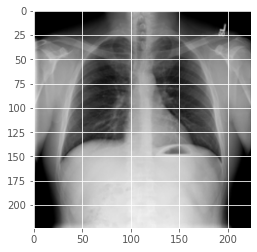

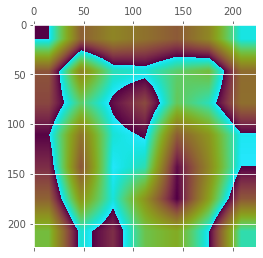

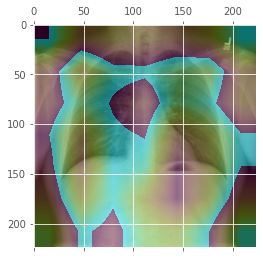

image2: Normal


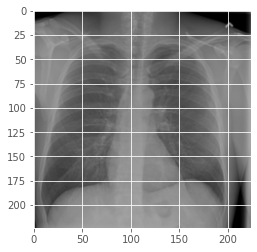

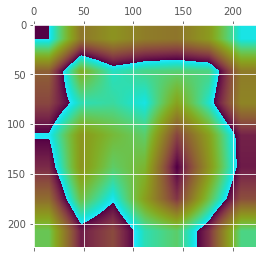

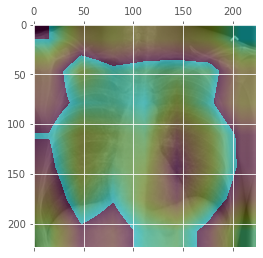

image2: Covid


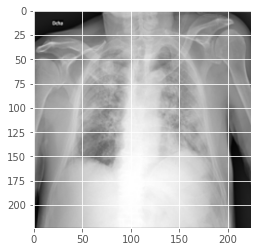

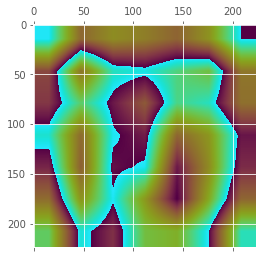

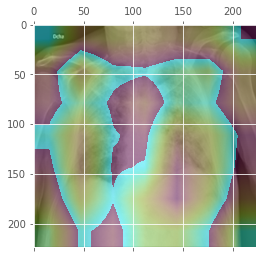

image2: Covid


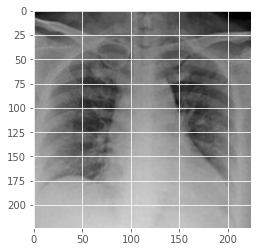

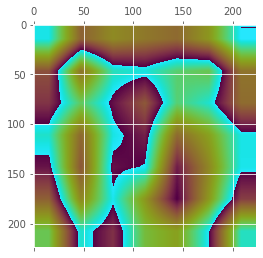

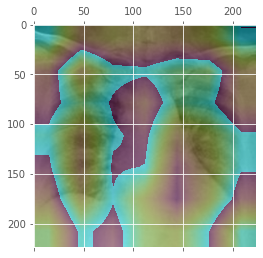

image5:Lung Opacity


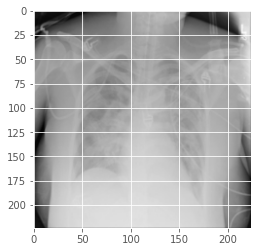

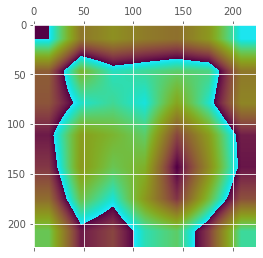

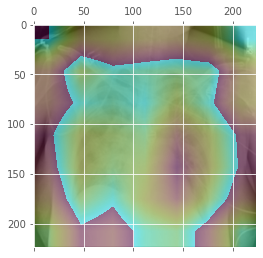

image6: Lung Opacity


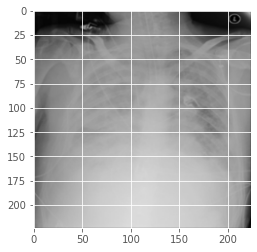

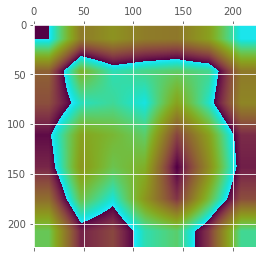

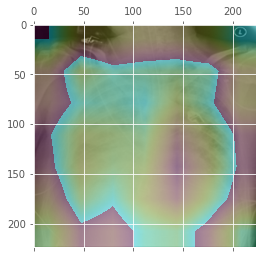

image7: Viral Pneumonia


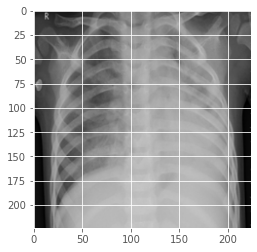

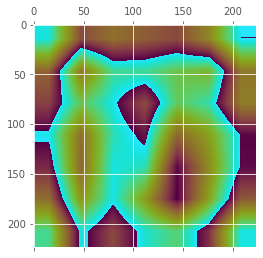

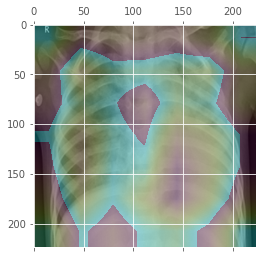

image8: Viral Pneumonia


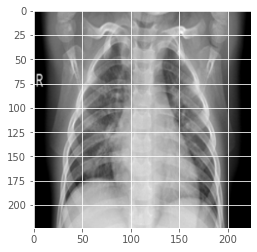

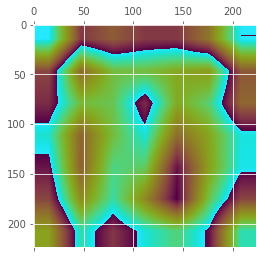

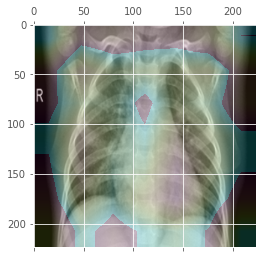

In [43]:
#image1
print("image1:Normal")
plt.imshow(image1)
plt.show()
plt.matshow(heatmap1)
plt.show()
plt.matshow(output1) 
plt.show()

#image 2
print("image2: Normal")
plt.imshow(image2)
plt.show()
plt.matshow(heatmap2)
plt.show()
plt.matshow(output2) 
plt.show()

print("image2: Covid")
#image 3
plt.imshow(image3)
plt.show()
plt.matshow(heatmap3)
plt.show()
plt.matshow(output3) 
plt.show()

print("image2: Covid")
#image 4
plt.imshow(image4)
plt.show()
plt.matshow(heatmap4)
plt.show()
plt.matshow(output4) 
plt.show()

#image5
print("image5:Lung Opacity")
plt.imshow(image5)
plt.show()
plt.matshow(heatmap5)
plt.show()
plt.matshow(output5) 
plt.show()

#image 6
print("image6: Lung Opacity")
plt.imshow(image6)
plt.show()
plt.matshow(heatmap6)
plt.show()
plt.matshow(output6) 
plt.show()

print("image7: Viral Pneumonia")
#image 7
plt.imshow(image7)
plt.show()
plt.matshow(heatmap7)
plt.show()
plt.matshow(output7) 
plt.show()

print("image8: Viral Pneumonia")
#image 8
plt.imshow(image8)
plt.show()
plt.matshow(heatmap8)
plt.show()
plt.matshow(output8) 
plt.show()

